<a href="https://colab.research.google.com/github/LQQQQQQ/Text_Analysis/blob/master/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification on LeMonde2003 Dataset

In this notebook, we 
apply classification algorithms to newspaper articles published in 2003 in Le Monde. The data are in data/LeMonde2003_9classes.csv.gzThese articles concern different subjects but we will consider only articles related to the following subjects : entreprises (ENT), international (INT), arts (ART), société (SOC), France (FRA), sports (SPO), livres (LIV), télévision (TEL) and the font page articles (UNE).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import ast
import os
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from keras.preprocessing import text, sequence
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging


Using TensorFlow backend.


In [0]:
# load dataframe from CSV file
data_dir = "/content/drive/My Drive/TA/LeMonde2003_raw.csv"
df = pd.read_csv(data_dir)

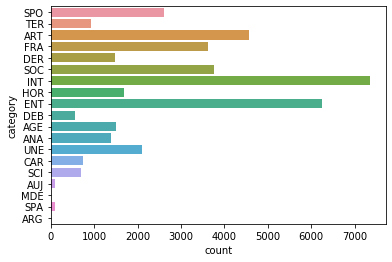

In [4]:
# Plot the statistics of category
sns.countplot(data=df,y='category')

In [0]:
# Print examples of the articles
print("shape of dataset: ")
print(df.shape)
print("example text: ")
print(df.iloc[151,0])
print("example category: ")
print(df.iloc[151,1])

shape of dataset: 
(39451, 2)
example text: 
C'EST un rituel urbain, observable dès la mi-mars. Il débute par un grand nettoyage de printemps sur le balcon et se prolonge dans les jardineries des grandes villes, prises d'assaut. Une ambiance de soldes pour une boulimie de verdure qui remplit jusqu'à ras bord les chariots chargés de sacs de terreau, couverts de plants de toutes sortes, débordants de jeunes tiges. Fête du jardin ? Plutôt fête de la terrasse, voire du rebord de fenêtre. La plupart des clients venus brûler la politesse aux hirondelles pour annoncer le printemps sont des jardiniers d'altitude ; rares sont ceux qui repiqueront leurs semis ailleurs que dans un bac. « Pour moi, passer la porte d'une jardinerie, c'est un point de repère symbolique dans l'année. Sans doute un vieux fond paysan qui ressurgit », s'amuse une quadragénaire qui avoue sa « hâte de sentir la terre » dans ses mains. Segment le plus dynamique du - florissant - marché du jardinage (7 milliards d'euros par

Il y a alors 39451 articles. 

In [0]:
!pip install wordcloud

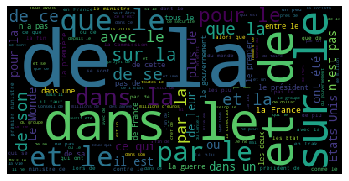

In [0]:
# Display one wordcloud for each of the most frequent classes
# df -> txt
txt = []
for i in df.iloc[:,0]: 
  txt.append(i)
for i in df.iloc[:,1]: 
  txt.append(i)
txt = str(txt)
# set stopwords 
with open('drive/My Drive/TA/stop_word_fr.txt','r',encoding='utf-8') as f:
  words= (f.read())
  f.close()
sw = set(words)
# cloud
my_wordcloud = WordCloud(stopwords=sw)
my_wordcloud.generate_from_text(txt) 
plt.imshow(my_wordcloud, cmap='Blues')
plt.axis("off") 
plt.show() 
# my_wordcloud.to_file("drive/My Drive/TA/pywordcloud.png")

# Bag-of-word representation

In order to apply machine learning algorithms to text, documents must be transformed into vectors. The most simple and standard way to transform a document into a vector is the bag-of-word encoding.The idea is very simple : 
define the set of all the possible words that can appear in a document; denote its size by max_features.
for each document,  encode it with a vector of size max_features, with the value of the ith component of the vector equal to the number of time the ith word appears in the document.

See the wikipedia article on Bag-of-word for an example.Scikit-learn proposes different methods to encode text into vectors : CountVectorizer and TfidfTransformer.The encoder must first be trained on the train set and applied to the different sets, for example with the 1000  words.


In [26]:
# Split the dataset, create X (features) and y (target), print the size
X = df.iloc[:,0]
y = df.iloc[:,1]
X.replace(',', "")
X.replace("'", "")
X.replace('.', "")
X.replace('"', "")
X.replace('?', '')
X.replace('!', "")
X.replace(':', '')
X.replace('\n', '')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train.fillna(value='',inplace=True)
X_test.fillna(value='',inplace=True)
y_train.fillna(value='',inplace=True)
y_test.fillna(value='',inplace=True)
print("shape of train set:")
print(X_train.shape)
print("shape of test set:")
print(X_test.shape)

shape of train set:
(31560,)
shape of test set:
(7891,)


In [0]:
# Create document vectors
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [7]:
# train a Naive Bayes classifier
clf_1 = MultinomialNB()
clf_1.fit(X_train_counts, y_train)
y_test_pred = clf_1.predict(X_test_counts)
test_score = accuracy_score(y_test, y_test_pred)
print("accuracy score for test set: ")
print(test_score)

accuracy score for test set: 
0.624255480927639


# TF-IDF representation
The CountVectorizer encodes the text using the raw frequencies of the words. However, words that are very frequent and appear in all the documents will have a strong weight whereas they are not discriminative. The Term-Frequency Inverse-Document-Frequency weighting scheme take into accound the number of documents in which a given word occurs. A word that appear in many document will have less weight. See the wikipedia page for more details.With scikit-learn, the TfidfTransformer is applied after the CountVectorizer.

In [0]:
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

In [29]:
# train a Naive Bayes classifier using tf_idf
clf_2 = MultinomialNB()
clf_2.fit(X_train_tf, y_train)
y_test_tf_pred = clf_2.predict(X_test_tf)
test_tf_score = accuracy_score(y_test, y_test_tf_pred)
print("accuracy score for test set: ")
print(test_tf_score)

accuracy score for test set: 
0.639462679001394


# Error analysis
The classification error rate give an evaluation of the performance for all the classes. But since the classes are not equally distributed, they may not be equally well modelized. In order to get a better idea of the performance of the classifier, detailed metrics must be used : 
metrics.classification_report provides a detailed analysis per class : the precision (amongst all the example classified as class X, how many are really from the classX) and the recall (amongst all the example that are from the class X, how many are classified as class X) and the F-Score which is as a weighted harmonic mean of the precision and recall.
metrics.confusion_matrix which give the confusions between the classes. It can be displayed in color with plot_confusion_matrix.

In [30]:
print(classification_report(y_test, y_test_tf_pred))

              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
         AGE       0.78      0.46      0.58       285
         ANA       0.89      0.09      0.17       259
         ART       0.56      0.88      0.68       890
         AUJ       0.00      0.00      0.00        20
         CAR       0.91      0.36      0.52       132
         DEB       0.71      0.05      0.09       100
         DER       0.89      0.17      0.28       281
         ENT       0.74      0.88      0.80      1311
         FRA       0.54      0.71      0.61       729
         HOR       0.37      0.12      0.18       342
         INT       0.62      0.89      0.73      1493
         MDE       0.00      0.00      0.00         1
         SCI       0.82      0.30      0.44       141
         SOC       0.58      0.64      0.61       790
         SPA       0.00      0.00      0.00        20
         SPO       0.87      0.83      0.85       482
         TER       0.72    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Les classes INT, ENT, ART, FRA, SOC et SPO ont les meilleurs scores. Elles ont beaucoup plus d'échantillons. 

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plot_conf_mat(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')
    plt.show()


[[   0    0    0    0    0    0    0    0    0    0    1    0    0    0
     0    0    0    0    0]
 [   0  132    0  121    0    0    0    0   23    0    1    1    0    1
     3    0    2    1    0]
 [   0    0   24   29    0    0    1    3   25   22    4  125    0    0
    19    0    6    0    1]
 [   0   13    0  781    0    0    0    0   20   20    2   34    0    1
    15    0    2    1    1]
 [   0   11    0    7    0    0    0    0    1    0    0    0    0    0
     1    0    0    0    0]
 [   0    0    0   49    0   48    0    0    3    3    0   19    0    0
     9    0    1    0    0]
 [   0    0    1   15    0    0    5    0    7   12   19   33    0    2
     6    0    0    0    0]
 [   0    0    0   59    0    0    0   47   30   28   11   76    0    0
    25    0    4    1    0]
 [   0    1    1   28    0    0    0    0 1153   34    0   62    0    1
    24    0    5    1    1]
 [   0    0    0   11    0    0    0    0   51  515    9   33    0    1
   106    0    2    0    1]


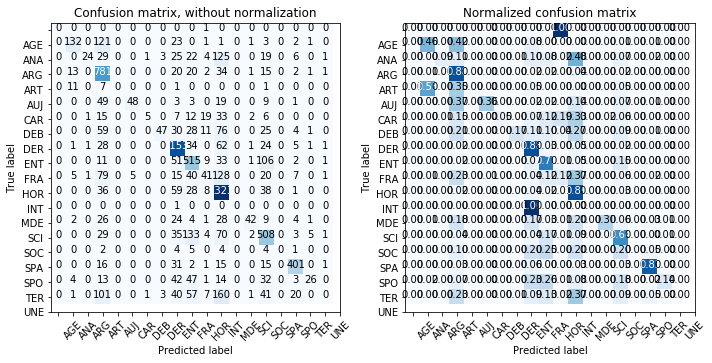

In [32]:
plot_conf_mat(y_test,y_test_tf_pred)

ARG, DER, HOR, SCI, SPA sont les plus confusing car ils existent pas trop dans le dataset. 

# Hyperparameter optimization
The classification process has many parameters : alpha for the classifier, max_features, max_df, min_df, using idf or not, ngram orders for the Count of TfIDF transformer. These parameters can be optimized by a grid search using GridSearchCV.

In [14]:
# Hyperameters optimization with GridSearchCV = parallel processing
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])


parameters = {'vect__max_df': [0.5, 0.75, 1.0],
              'vect__min_df': [0.0, 0.5],
              'vect__max_features': [1000, 2000],
              'vect__ngram_range': [(1,1), (2,2)],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [0.1, 0.5]}
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2)
    X_train_, X_train_dev, y_train_, y_train_dev = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=0.33)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train_dev.iloc[:1000], y_train_dev.iloc[:1000])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': [0.1, 0.5],
 'tfidf__use_idf': [True, False],
 'vect__max_df': [0.5, 0.75, 1.0],
 'vect__max_features': [1000, 2000],
 'vect__min_df': [0.0, 0.5],
 'vect__ngram_range': [(1, 1), (2, 2)]}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.6min finished


done in 153.547s

Best score: 0.609
Best parameters set:
	clf__alpha: 0.1
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: 2000
	vect__min_df: 0.0
	vect__ngram_range: (1, 1)


# Classification with Neural networks
Neural networks can be trained to learn both the vector representation of the words (instead of tf-idf) and how to classify the documents. The code below allows you to train a neural text classifier using word embeddings using Keras. Most of the code is written, you only have to define the architecture of the network with the correct parameters before training it

In [0]:
# Model parameters
MAX_FEATURES = 10000
MAX_TEXT_LENGTH = 1024
EMBED_SIZE  = 300
BATCH_SIZE = 16
EPOCHS = 10
VALIDATION_SPLIT = 0.1

In [0]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)



def get_model():

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_FEATURES, EMBED_SIZE)(inp)
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(7, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y, history):
    
    model.fit(x_train, y,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)

In [36]:
# Get the list of different classes
y_label = np.hstack((y_train,y_test))
CLASSES_LIST = np.unique(y_label
                         )
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert clas string to index
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(X_train, X_test)
print(len(x_vec_train), len(x_vec_test))

# define the NN topology
model = get_model()

# Define training procedure
history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)


print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in np.unique(y_train) ])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in np.unique(y_train)]))

['' 'AGE' 'ANA' 'ARG' 'ART' 'AUJ' 'CAR' 'DEB' 'DER' 'ENT' 'FRA' 'HOR'
 'INT' 'MDE' 'SCI' 'SOC' 'SPA' 'SPO' 'TER' 'UNE']
31560 7891
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1024, 300)         3000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1024, 32)          19232     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
